In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# load MR images dataset
import pickle
mri_file = open("/content/drive/MyDrive/MRI-Medical-Images-Denoising/mri_dataset/mri_imgs.pickle", 'rb')
mri_imgs= pickle.load(mri_file)
print(type(mri_imgs))
print(mri_imgs.shape)

<class 'numpy.ndarray'>
(7087, 128, 128, 3)


In [ ]:
# split train and test images
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(mri_imgs, test_size = 0.2, train_size = 0.8, shuffle = True, random_state = 0)

In [ ]:
# shape of train and test images
print(x_train.shape)
print(x_test.shape)

(5669, 128, 128, 3)
(1418, 128, 128, 3)


In [ ]:
# convert float types and normalize mri images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.dtype)
print(x_test.dtype)

float32
float32


In [ ]:
# reshape into tensor
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
print(x_train.shape)
print(x_test.shape)

(5669, 128, 128, 3)
(1418, 128, 128, 3)


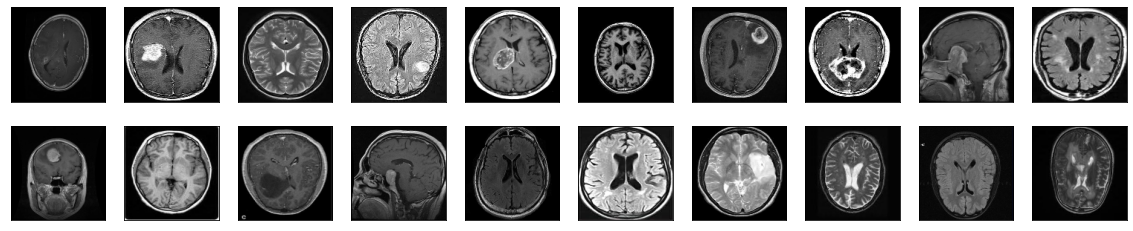

In [ ]:
# show some training mri images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(x_train[idx])

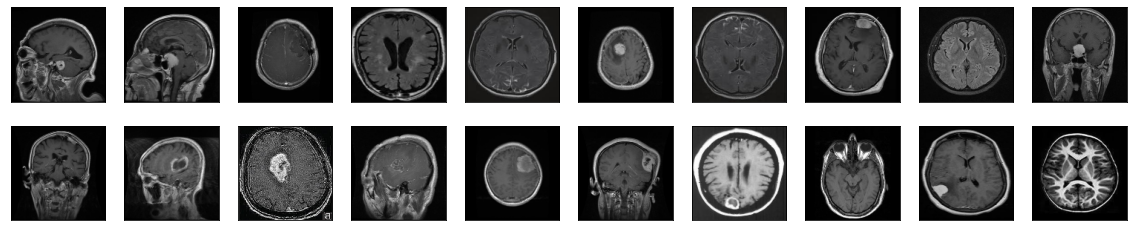

In [ ]:
# show some testing mri images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(x_test[idx])

# Add Salt and Peper Noise in images

In [ ]:
from skimage.util import random_noise

In [ ]:
sp_noise_x_train = random_noise(x_train, mode = 's&p', amount = 0.3)
sp_noise_x_test = random_noise(x_test, mode = 's&p', amount = 0.3)

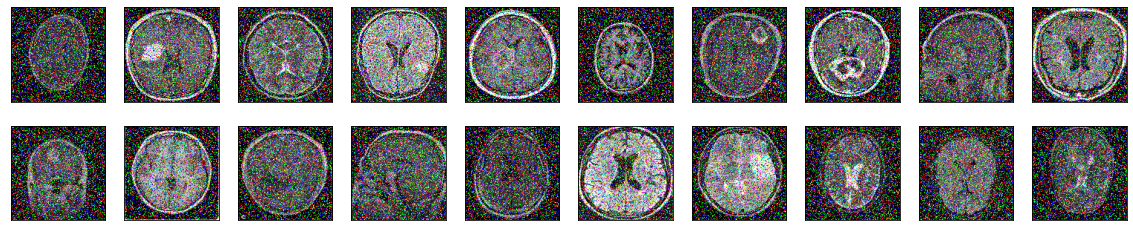

In [ ]:
# show some noisy mri images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(sp_noise_x_train[idx])

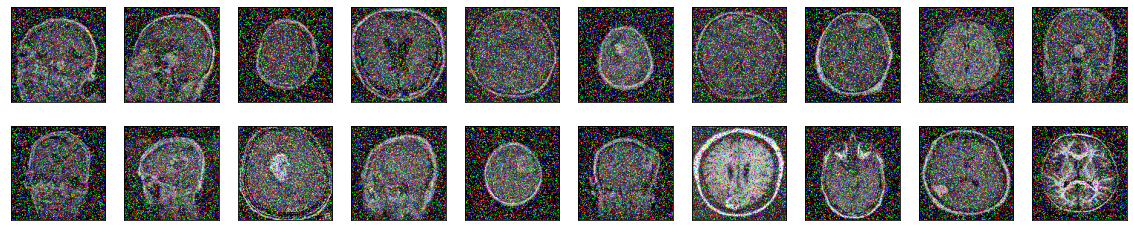

In [ ]:
# show some restored images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(sp_noise_x_test[idx])

In [ ]:
# define encoder
inputs = layers.Input(shape = [128, 128, 3])
x = inputs

c1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
c1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c1)
c1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c1)
c1 = tf.keras.layers.Dropout(0.2)(c1)
  
c2 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c1)
c2 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c2)
c2 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c2)
c2 = tf.keras.layers.Dropout(0.2)(c2)

c3 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c2)
c3 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c3)
c3 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)

c4 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c3)
c4 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c4)
c4 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)

c5 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c4)
c5 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c5)
c5 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c5)
c5 = tf.keras.layers.Dropout(0.2)(c5)

c6 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c5)
c6 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(c6)
c6 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c6)
c6 = tf.keras.layers.Dropout(0.2)(c6)

# define decoder
u1 = Conv2DTranspose(filters = 512, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(c6)
u1 = tf.keras.layers.add([u1, c5])
u1 = concatenate([u1, c5])
u1 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u1)
u1 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u1)
u1 = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)

u2 = Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(u1)
u2 = tf.keras.layers.add([u2, c4])
u2 = concatenate([u2, c4])
u2 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u2)
u2 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u2)
u2 = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)

u3 = Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(u2)
u3 = tf.keras.layers.add([u3, c3])
u3 = concatenate([u3, c3])
u3 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u3)
u3 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u3)
u3 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)

u4 = Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(u3)
u4 = tf.keras.layers.add([u4, c2])
u4 = concatenate([u4, c2])
u4 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u4)
u4 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u4)
u4 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)

u5 = Conv2DTranspose(filters = 32, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(u4)
u5 = tf.keras.layers.add([u5, c1])
u5 = concatenate([u5, c1])
u5 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u5)
u5 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u5)
u5 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u5)
u5 = tf.keras.layers.Dropout(0.2)(u5)

u6 = Conv2DTranspose(filters = 1, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(u5)
u6 = tf.keras.layers.add([u6, x])
u6 = concatenate([u6, x])
u6 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u6)
u6 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u6)
u6 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(u6)
u6 = tf.keras.layers.Dropout(0.2)(u6)

out = Conv2D(filters = 3, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'sigmoid')(u6)
out = tf.keras.layers.add([tf.constant(0.003)*inputs, out])

model = Model(inputs = inputs, outputs = out, name = 'Eecoder-Decoder')
model.summary()

Model: "Eecoder-Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                   

In [ ]:
model_path = '/content/drive/MyDrive/MRI-Medical-Images-Denoising/Models/s&p_model.h5'
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 20)

callbacks_list = [checkpoint, early]

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.fit(sp_noise_x_train, x_train,
                      validation_data = (sp_noise_x_test, x_test),
                      epochs = 100, batch_size = 50, callbacks = callbacks_list)

Epoch 1/100
114/114 [==============================] - ETA: 0s - loss: 0.0310
Epoch 1: val_loss improved from inf to 0.01023, saving model to /content/drive/MyDrive/MRI-Medical-Images-Denoising/Models/s&p_model.h5
114/114 [==============================] - 157s 1s/step - loss: 0.0310 - val_loss: 0.0102
Epoch 2/100
114/114 [==============================] - ETA: 0s - loss: 0.0094
Epoch 2: val_loss improved from 0.01023 to 0.00748, saving model to /content/drive/MyDrive/MRI-Medical-Images-Denoising/Models/s&p_model.h5
114/114 [==============================] - 120s 1s/step - loss: 0.0094 - val_loss: 0.0075
Epoch 3/100
114/114 [==============================] - ETA: 0s - loss: 0.0076
Epoch 3: val_loss improved from 0.00748 to 0.00674, saving model to /content/drive/MyDrive/MRI-Medical-Images-Denoising/Models/s&p_model.h5
114/114 [==============================] - 119s 1s/step - loss: 0.0076 - val_loss: 0.0067
Epoch 4/100
114/114 [==============================] - ETA: 0s - loss: 0.0068
Ep

No handles with labels found to put in legend.


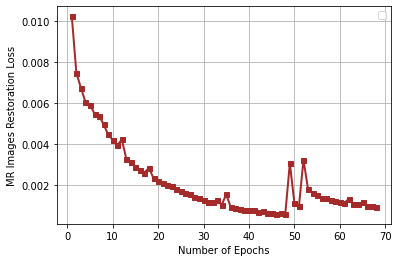

In [ ]:
val_loss_values = model.history.history['val_loss']
epochs = range(1, len(val_loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values)
plt.setp(line1, linewidth = 2, marker = 's', markersize = 5, color = 'brown')
plt.xlabel('Number of Epochs') 
plt.ylabel('MR Images Restoration Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/MRI-Medical-Images-Denoising/Models/s&p_model.h5")

In [ ]:
output_images = model.predict(sp_noise_x_test)

In [ ]:
psnr = tf.image.psnr(output_images, x_test, max_val = 255)
psnr.numpy().mean()

82.37923

In [ ]:
ssim = tf.image.ssim(output_images, x_test, 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
round(ssim.numpy().mean(), 4)

0.9626

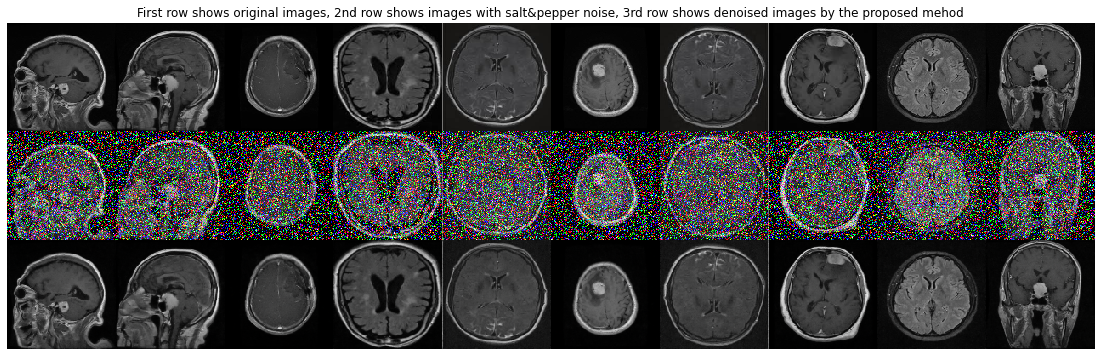

In [ ]:
# display the 1st 8 test input and decoded images

imgs = np.concatenate([x_test[:10] ,sp_noise_x_test[:10], output_images[:10]])
imgs = imgs.reshape((3, 10, 128, 128, 3))

imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (24, 6))
plt.axis('off')
plt.title('First row shows original images, 2nd row shows images with salt&pepper noise, 3rd row shows denoised images by the proposed mehod')
plt.imshow(imgs, interpolation='none', cmap = 'gray')